# Eigenface for Face Recognition

In [1]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
import matplotlib.pyplot as p
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Load Train and Test Set

The training set and the test sets have the expected dimensions described in the problem set.

The training set contains 10 balanced classes of images.

In [2]:
def read_files(file_path):
    """
        Create lists of images and labels  
        @P: file path of the image files
            
        @R: label_arr (list): array for the labels
            data_arr (list): array for the images in the dataset
    """
    labels_lst, img_lst = [], []
    
    for line in open(file_path):
        f=line.strip().split()[0]
        f_lst=f.split("/")
        f_lst[0]="input"
        f_name="/".join(f_lst)
        im=p.imread(f_name)
        img_lst.append(im.reshape(2500,))
        labels_lst.append(line.strip().split()[1])
        
    img_lst, labels_lst = np.array(img_lst, dtype=float), np.array(labels_lst, dtype=int)    
    print(img_lst.shape, labels_lst.shape)
    
    return img_lst, labels_lst

(540, 2500) (540,)


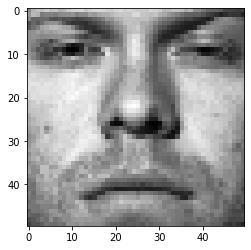

In [3]:
X, train_labels = read_files('input/faces/train.txt')
plt.imshow(X[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

<AxesSubplot:ylabel='Percent'>

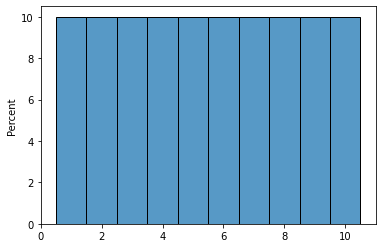

In [4]:
sns.histplot(data=train_labels, stat="percent", discrete=True)

In [5]:
X_test, test_labels = read_files('input/faces/test.txt')

(100, 2500) (100,)


# Average Face

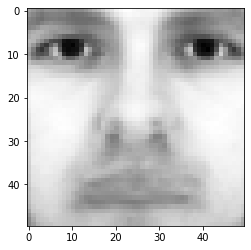

In [6]:
u=X.sum(axis=0)/X.shape[0]
u_img=np.array(u, dtype=float)
plt.imshow(u_img.reshape(50,50), cmap = cm.Greys_r)
plt.show()

# Mean Subtraction

The mean is subtracted using the methodology described to center the images at the mean, resulting in a standardized dataset.

Reference:

https://math.stackexchange.com/questions/317114/what-is-the-purpose-of-subtracting-the-mean-from-data-when-standardizing

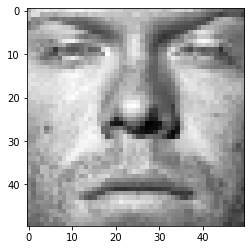

In [7]:
avg_X=X-u
plt.imshow(avg_X[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

In [8]:
avg_X_test=X_test-u

# Eigenface

The principle components and the eigen values are calculated using the code from the lecture slides.

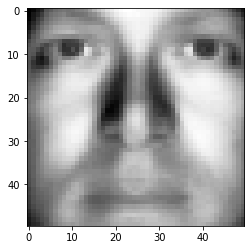

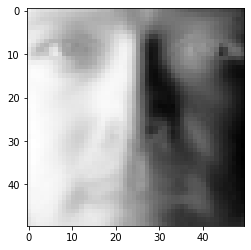

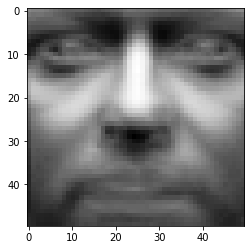

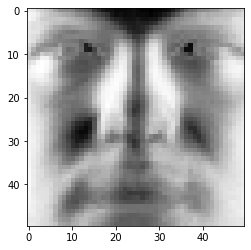

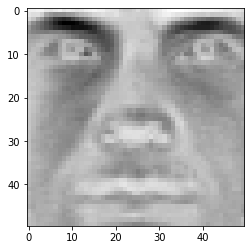

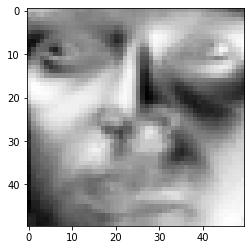

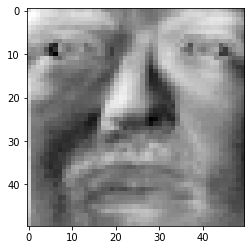

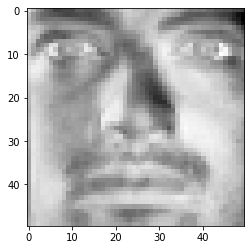

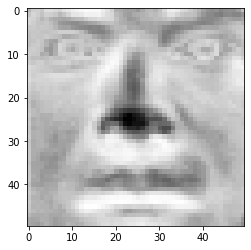

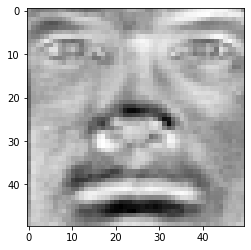

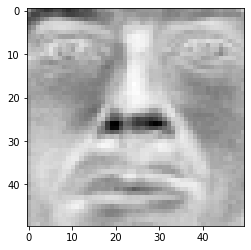

In [21]:
Sigma = avg_X.T.dot(avg_X) / avg_X.shape[0] # form covariance matrix
L, Q = np.linalg.eig(Sigma) # perform eigendecomposition (eigen value and eigen vectors)
L=L.real
Q=Q.real

eigen_vectors_transpose=Q.T

for i in range(11):
    r=eigen_vectors_transpose[i,:]
    r=np.array(r, dtype=float)
    plt.imshow(r.reshape(50,50), cmap = cm.Greys_r)
    plt.show()

# Eigenface Feature

As we discussed in our class on Dimentionality Reduction, I used the elbow method to find the components that captured 80% of the the variance in the dataset. The result showed that the first 3 components do this in the data.

I projected the standardized data on those 3 componenents using the code from the lecture on Dimensionality Reduction.

Reference:

- https://rpubs.com/jefflittlejohn/Data605_HW4
- https://www.digitalocean.com/community/tutorials/seaborn-line-plot

Select the first 3 eigen vectors to project onto as they represent ~80% of the variance in the dataset

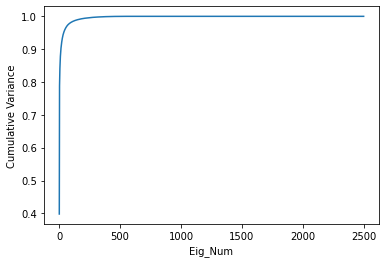

In [10]:
cum_var = L.cumsum() / sum(L)
num_eig=[i for i in range(1,len(L)+1)]

data_plot = pd.DataFrame({"Eig_Num":num_eig, "Cumulative Variance":cum_var})

sns.lineplot(x = "Eig_Num", y = "Cumulative Variance", data=data_plot)
plt.show()

In [11]:
thres_df=data_plot[data_plot["Cumulative Variance"]>=0.8]
thres_df.head(1)

,Eig_Num,Cumulative Variance
3,4,0.813227


In [12]:
def eigen_feature(Eig_vect,rw_data,r):
    """
        Project the datasets on the first few principle components.
        
        @P: 
            Eig_vect(matrix): all the eigenvectors 
            rw_data (matrix): all the data in the matrix
            r (int): threshold for the number of eigenvectors
            
        @R:
            Z (matrix): the raw data projected onto the selected principle components
    """
    
    W = Eig_vect[:,:r] # get top r eigenvectors
    Z = rw_data.dot(W) # project on these eigenvectors
    return Z

F=eigen_feature(Q,avg_X,3)
F.shape

(540, 3)

In [13]:
F_test=eigen_feature(Q,avg_X_test,3)
F_test.shape

(100, 3)

# Face Recognition

10 eigenvectors result in an accuracy of 77%

The training accuracy drastically improves as the number of principle components increases from 1 to 25. After 25 principles, the accuracy remains consistent at ~90%. 

I expected the training accuracy to plateu after a certain number of principle components, but I was surprised that the number was 25 components, I kind of thought it would be closer to 3 components. The first 3 components capture ~80% of the variance in the images.

Training the Logistic Regression model with 10 principles and using "one-vs-rest" resulted in a classification accuracy of 80%, which is slightly more than the first result of 77%. A draw-back to this approach is that there are 10 classes, so 10 models had to be trained.


References:

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

In [14]:
F=eigen_feature(Q,avg_X,10)
F_test=eigen_feature(Q,avg_X_test,10)
lf = LogisticRegression(penalty='none').fit(F, train_labels)
pred=lf.predict(F_test)
print("Classification accurary on the test set: {}".format(accuracy_score(test_labels, pred)))

Classification accurary on the test set: 0.77


In [15]:
r_vals=[r for r in range(1,201)]
accur_scr_lst=[]
for r in range(1,201):
    F=eigen_feature(Q,avg_X,r)
    F_test=eigen_feature(Q,avg_X_test,r)
    lf = LogisticRegression(penalty='none').fit(F, train_labels)
    pred=lf.predict(F_test)
    ac_sc=accuracy_score(test_labels, pred)
    accur_scr_lst.append(ac_sc)

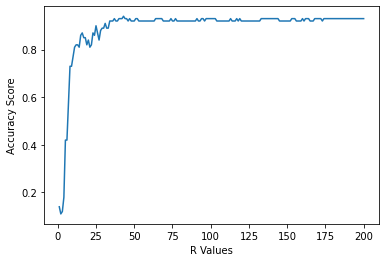

In [16]:
data_plot = pd.DataFrame({"R Values":r_vals, "Accuracy Score":accur_scr_lst})

sns.lineplot(x = "R Values", y = "Accuracy Score", data=data_plot)
plt.show()

In [17]:
ac_df=data_plot[data_plot["Accuracy Score"]>=0.9]
ac_df.head(20)

,R Values,Accuracy Score
24,25,0.90
30,31,0.91
33,34,0.92
34,35,0.92
35,36,0.92
36,37,0.93
37,38,0.92
38,39,0.92
39,40,0.93
40,41,0.93


In [18]:
F=eigen_feature(Q,avg_X,10)
F_test=eigen_feature(Q,avg_X_test,10)
lf = LogisticRegression(penalty='none',multi_class="ovr").fit(F, train_labels)
pred=lf.predict(F_test)
print("Classification accurary on the test set when trained using the 'one-vs-rest': {}".format(accuracy_score(test_labels, pred)))

Classification accurary on the test set when trained using the 'one-vs-rest': 0.8
